In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import logging
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sep
import pandas as pd
import os
from astropy.table import Table, vstack
import galcheat

import matplotlib.image as mpimg
import matplotlib as mpl

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

/tmp/ipykernel_21923/2955896611.py:16: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command


In [ ]:
survey=galcheat.get_survey("LSST")

In [ ]:
from maddeb.utils import listdir_fullpath, get_data_dir_path
import maddeb.boxplot

def format_func(value, tick_number):
    # Format the y-axis labels as integers without decimals
    return '{:.3f}'.format(value)

In [ ]:
logging.basicConfig(format="%(message)s", level=logging.INFO)
LOG = logging.getLogger(__name__)

## load the saved results

In [ ]:
density_level = "high"

In [ ]:
data_path = "/sps/lsst/users/bbiswas/MADNESS_results/" + density_level + "_density"
run_name = "kl1" # 12 to 20 galaxies
result_dir_path = os.path.join(data_path, run_name)

In [ ]:
scarlet_plot_color = sns.color_palette("colorblind")[4]
madness_plot_color = sns.color_palette("colorblind")[0]
debvader_plot_color = sns.color_palette("colorblind")[2]

isolated_plot_color = sns.color_palette("colorblind")[6]
blended_plot_color = sns.color_palette("colorblind")[1]

madness_plot_ls = "dashdot"
debvader_plot_ls = "dotted"
scarlet_plot_ls = "-"

isolated_plot_ls = "dotted"
blended_plot_ls = "--"

scarlet_plot_label = r'\texttt{scarlet}'
madness_plot_label = r'\texttt{MADNESS}'
debvader_plot_label = r'\texttt{VAE-deblender}'

In [ ]:
madness_results=[]
debvader_results=[]
scarlet_results=[]
actual_photometry = []
blended_photometry = []

for file_num in range(300):

    madness_results.append(pd.read_pickle(os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl")))
    debvader_results.append(pd.read_pickle(os.path.join(result_dir_path, "debvader_results", str(file_num) + ".pkl")))
    scarlet_results.append(pd.read_pickle(os.path.join(data_path, "scarlet_results", str(file_num) + ".pkl")))

    actual_photometry.append(pd.read_pickle(os.path.join(data_path, "actual_photometry", str(file_num) + ".pkl")))
    blended_photometry.append(pd.read_pickle(os.path.join(data_path, "blended_photometry",  str(file_num) + ".pkl")))

madness_results = pd.concat(madness_results)
debvader_results = pd.concat(debvader_results)
scarlet_results = pd.concat(scarlet_results)

actual_photometry = pd.concat(actual_photometry)
blended_photometry = pd.concat(blended_photometry)

In [ ]:
# mask_contamination=madness_results["r_contamination"].values<5
# madness_results=madness_results[mask_contamination]
# scarlet_results=scarlet_results[mask_contamination]
# actual_photometry=actual_photometry[mask_contamination]
# blended_photometry=blended_photometry[mask_contamination]

In [ ]:
from scipy.optimize import curve_fit
def gauss(x, sig, mu):
    return 1/np.sqrt(2.*np.pi)/sig*np.exp(-0.5*(x-mu)**2/sig**2)

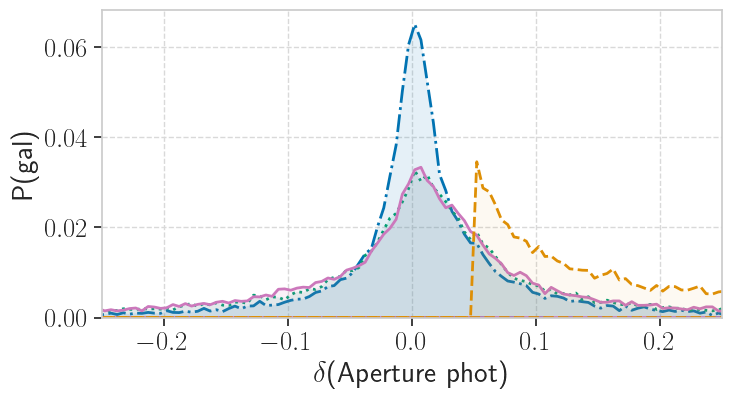

In [ ]:

band='r'
mask = madness_results['r_contamination']>.05
bins = np.arange(-10, 10, .005)



plt.figure(figsize=(8, 4))
sns.set(font_scale=1.75)
sns.set_style("whitegrid", {"grid.color": ".85", 'grid.linestyle': '--'})
madness_rel_aper_phot_err = (madness_results[band+"_phot_flux"].values[mask] / actual_photometry[band+"_phot_flux"].values[mask] - 1)
sns.histplot(
    madness_results[band+"_phot_flux"].values[mask] / actual_photometry[band+"_phot_flux"].values[mask] - 1, 
    bins=bins,
    label=madness_plot_label,
    color=madness_plot_color,
    alpha=.1,
    element="poly",
    stat='probability',
    ls=madness_plot_ls,
    lw=2,
)
# print(np.sqrt(np.sum((madness_rel_aper_phot_err - np.mean(madness_rel_aper_phot_err))**2)/len(madness_rel_aper_phot_err)))
# hist, bin_tmp = np.histogram((madness_results[band+"_phot_flux"].values[mask] / actual_photometry[band+"_phot_flux"].values[mask] - 1), bins, density=True)
# bins = np.mean((bin_tmp[:-1], bin_tmp[1:]), 0)
# res = curve_fit(gauss, bins, hist, p0=[.001, 0])
# print(res[0])
# plt.plot(bins, gauss(bins, res[0][0], res[0][1]))


sns.histplot(
    debvader_results[band+"_phot_flux"].values[mask] / actual_photometry[band+"_phot_flux"].values[mask] - 1, 
    bins=bins,
    label=debvader_plot_label,
    color=debvader_plot_color,
    alpha=.1, 
    element="poly",
    stat='probability',
    ls = debvader_plot_ls,
    lw=2,
)
scarlet_rel_aper_phot_err = (scarlet_results[band+"_phot_flux"].values[mask] / actual_photometry[band+"_phot_flux"].values[mask] - 1)
sns.histplot(
    scarlet_results[band+"_phot_flux"].values[mask]  / actual_photometry[band+"_phot_flux"].values[mask] - 1, 
    bins=bins,
    label=scarlet_plot_label,
    color=scarlet_plot_color,
    alpha=.1, 
    element="poly",
    stat='probability',
    ls=scarlet_plot_ls,
    lw=2,
)
sns.histplot(
    blended_photometry[band+"_phot_flux"].values[mask] / actual_photometry[band+"_phot_flux"].values[mask] - 1, 
    bins=bins,
    label="blended",
    color=blended_plot_color,
    alpha=.05, 
    element="poly",
    stat='probability',
    ls = blended_plot_ls,
    lw=2,
)
ax=plt.gca()
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

plt.xlabel(r'$\delta$(Aperture phot)')
plt.ylabel("P(gal)")
plt.xlim(-.25, .25)
plt.legend(loc='upper left')
ax.legend().remove()

plt.savefig(os.path.join("results", density_level + "_density", "aper_phot_distrib_"+band), bbox_inches="tight")
plt.savefig(os.path.join("results", density_level + "_density", "aper_phot_distrib_"+band+".pdf"), format="pdf", bbox_inches="tight")

# Pixel Cosine Distance

In [ ]:
bins = np.arange(0.95, 1, 0.0002)
for band_number, band in enumerate(survey.available_filters):
    plt.figure(figsize=(8, 4))
    sns.set(font_scale=1.75)
    sns.set_style("whitegrid", {"grid.color": ".85", 'grid.linestyle': '--'})
    mask = (actual_photometry[band+"_phot_flux"].values/actual_photometry[band+"_phot_fluxerrs"].values)>5
    sns.histplot(
        madness_results[mask][band + '_cosd'].values, bins=bins, 
        alpha=0.05, 
        label=madness_plot_label, 
        color=madness_plot_color, 
        element="poly", 
        stat='probability', 
        ls=madness_plot_ls,
        lw=2,
    )
    sns.histplot(
        debvader_results[mask][band + '_cosd'].values, 
        bins=bins, 
        alpha=0.05, 
        label=debvader_plot_label, 
        color=debvader_plot_color, 
        element="poly", 
        stat='probability', 
        ls=debvader_plot_ls, 
        lw=2,
    )
    sns.histplot(
        scarlet_results[mask][band + '_cosd'].values, 
        bins=bins, 
        alpha=0.05, 
        label=scarlet_plot_label, 
        color=scarlet_plot_color, 
        element="poly", 
        stat='probability', 
        ls=scarlet_plot_ls,
        lw=2,
    )
    plt.legend(title=band+"-filter", loc="upper left")
    ax=plt.gca()
    
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    if band !='u':
        ax.get_legend().remove()
    plt.xlim([0.975, 1])
    plt.ylim([0, .125])
    plt.xlabel(r"Cosine similarity($S_c$)")
    plt.ylabel("P(gal)")
    
    plt.tight_layout()
    #plt.savefig(result_dir_path + "/cosd_res_"+band)
    plt.savefig(os.path.join("results", density_level + "_density", "cosd_res_"+band), bbox_inches="tight")
    plt.savefig(os.path.join("results", density_level + "_density", "cosd_res_"+band+".pdf"), format="pdf", bbox_inches="tight")
    plt.close()

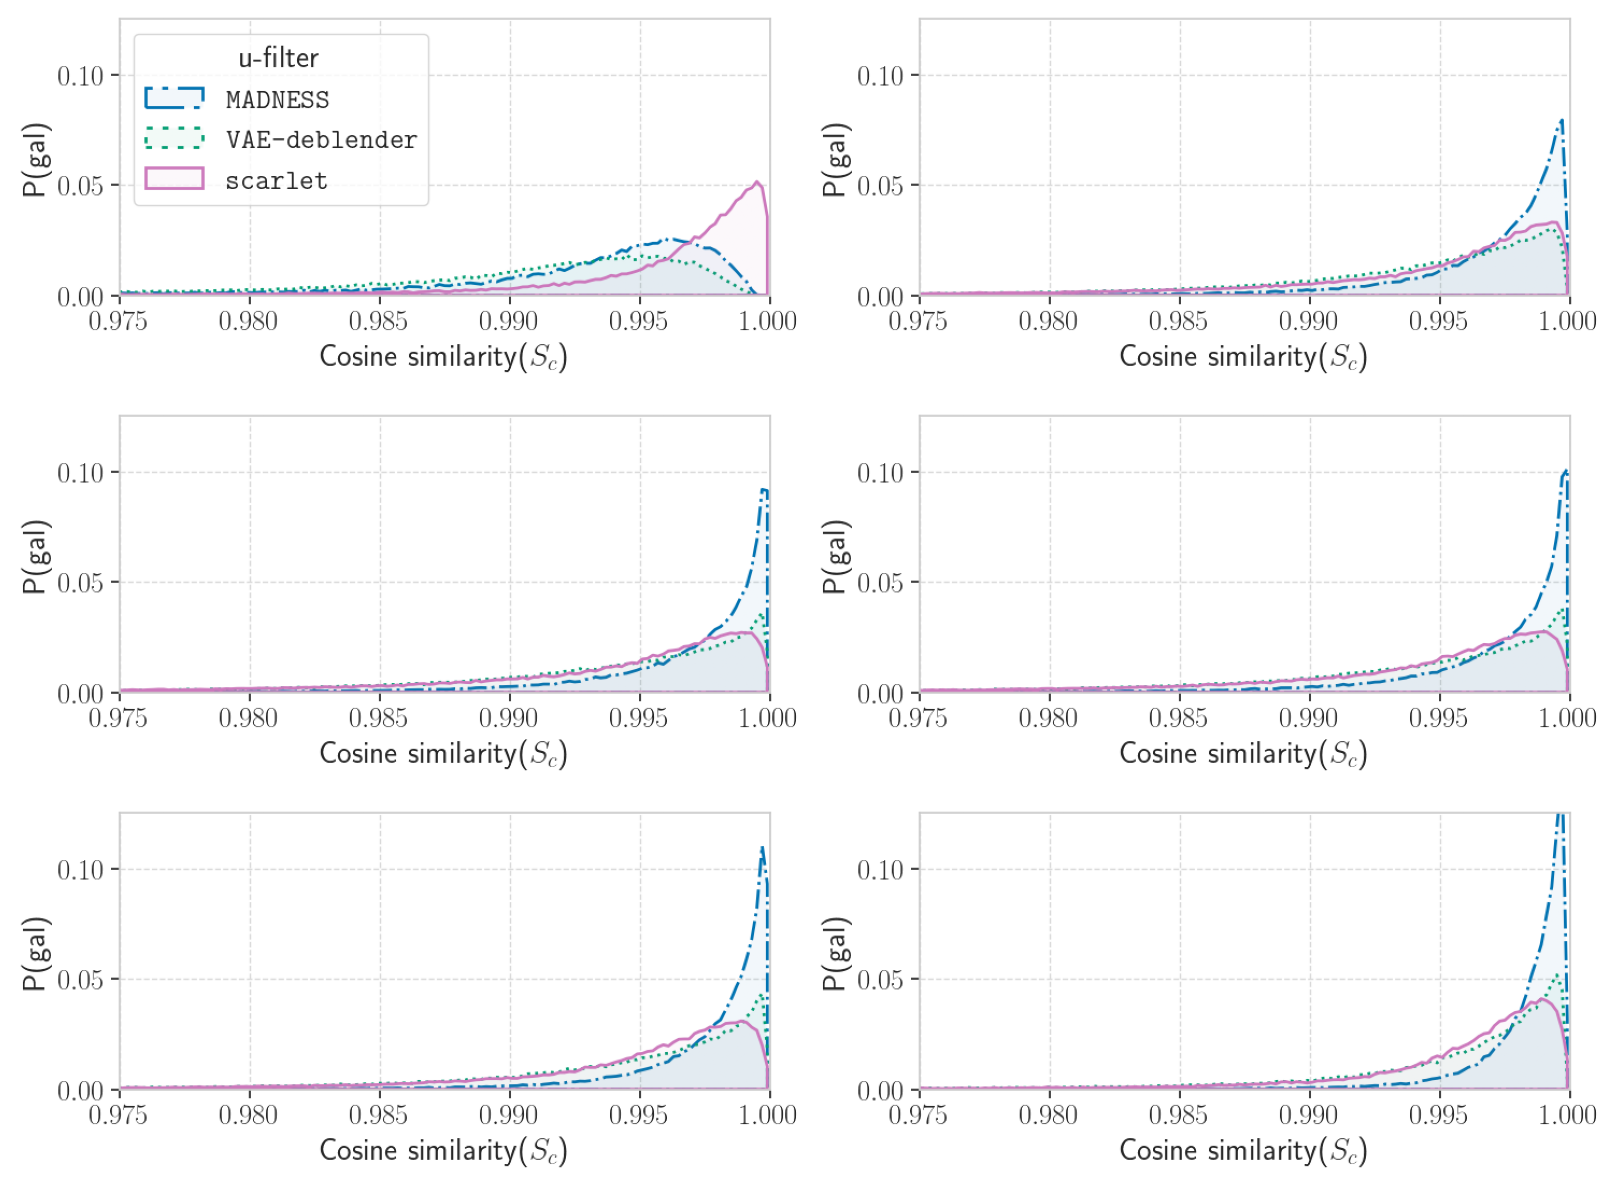

In [ ]:
f, axarr = plt.subplots(3, 2, figsize=(16, 12))

for band_num, band in enumerate(survey.available_filters):
#axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))
    axarr[int(band_num/2)][band_num%2].imshow(mpimg.imread(os.path.join("results", density_level + "_density", f"cosd_res_{band}.png")))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout(pad=0)


plt.savefig(os.path.join("results", density_level + "_density", "cosd_res.pdf"), format="pdf", bbox_inches="tight", dpi=1200)
plt.savefig(os.path.join("results", density_level + "_density", "cosd_res.png"))

plt.show()

# SSIM

In [ ]:
import matplotlib.ticker as ticker
bins = np.arange(0.9975, 1, 0.00002)
for band_number, band in enumerate(survey.available_filters):
    plt.figure(figsize=(8, 4))
    ax=plt.gca()
    #ax.yaxis.set_major_formatter(ticker.StrMethodFormatter(f'{{x:.3f}}'))
    sns.set(font_scale=1.75)
    sns.set_style("whitegrid", {"grid.color": ".85", 'grid.linestyle': '--'})
    mask = (actual_photometry[band+"_phot_flux"].values/actual_photometry[band+"_phot_fluxerrs"].values)>5
    sns.histplot(
        madness_results[mask][band + '_ssim'].values, bins=bins, 
        alpha=0.05, 
        label=madness_plot_label, 
        color=madness_plot_color, 
        element="poly", 
        stat='probability', 
        ls=madness_plot_ls,
        lw=2,
    )
    sns.histplot(
        debvader_results[mask][band + '_ssim'].values, 
        bins=bins, 
        alpha=0.05, 
        label=debvader_plot_label, 
        color=debvader_plot_color, 
        element="poly", 
        stat='probability', 
        ls=debvader_plot_ls, 
        lw=2,
    )
    sns.histplot(
        scarlet_results[mask][band + '_ssim'].values, 
        bins=bins, 
        alpha=0.05, 
        label=scarlet_plot_label, 
        color=scarlet_plot_color, 
        element="poly", 
        stat='probability', 
        ls=scarlet_plot_ls,
        lw=2,
    )
    plt.legend(title=band+"-filter", loc="upper left")
    ax = plt.gca()
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    if band !='u':
        ax.get_legend().remove()
    plt.xlim([0.9975, 1])
    plt.ylim([0, .185])
    plt.xlabel("SSIM")
    plt.ylabel("p(gal)")
    plt.tight_layout()
    #plt.savefig(result_dir_path + "/cosd_res_"+band)
    plt.savefig(os.path.join("results", density_level + "_density", "ssim_res_"+band), bbox_inches="tight")
    plt.savefig(os.path.join("results", density_level + "_density", "ssim_res_"+band+".pdf"), format="pdf", bbox_inches="tight")
    plt.close()

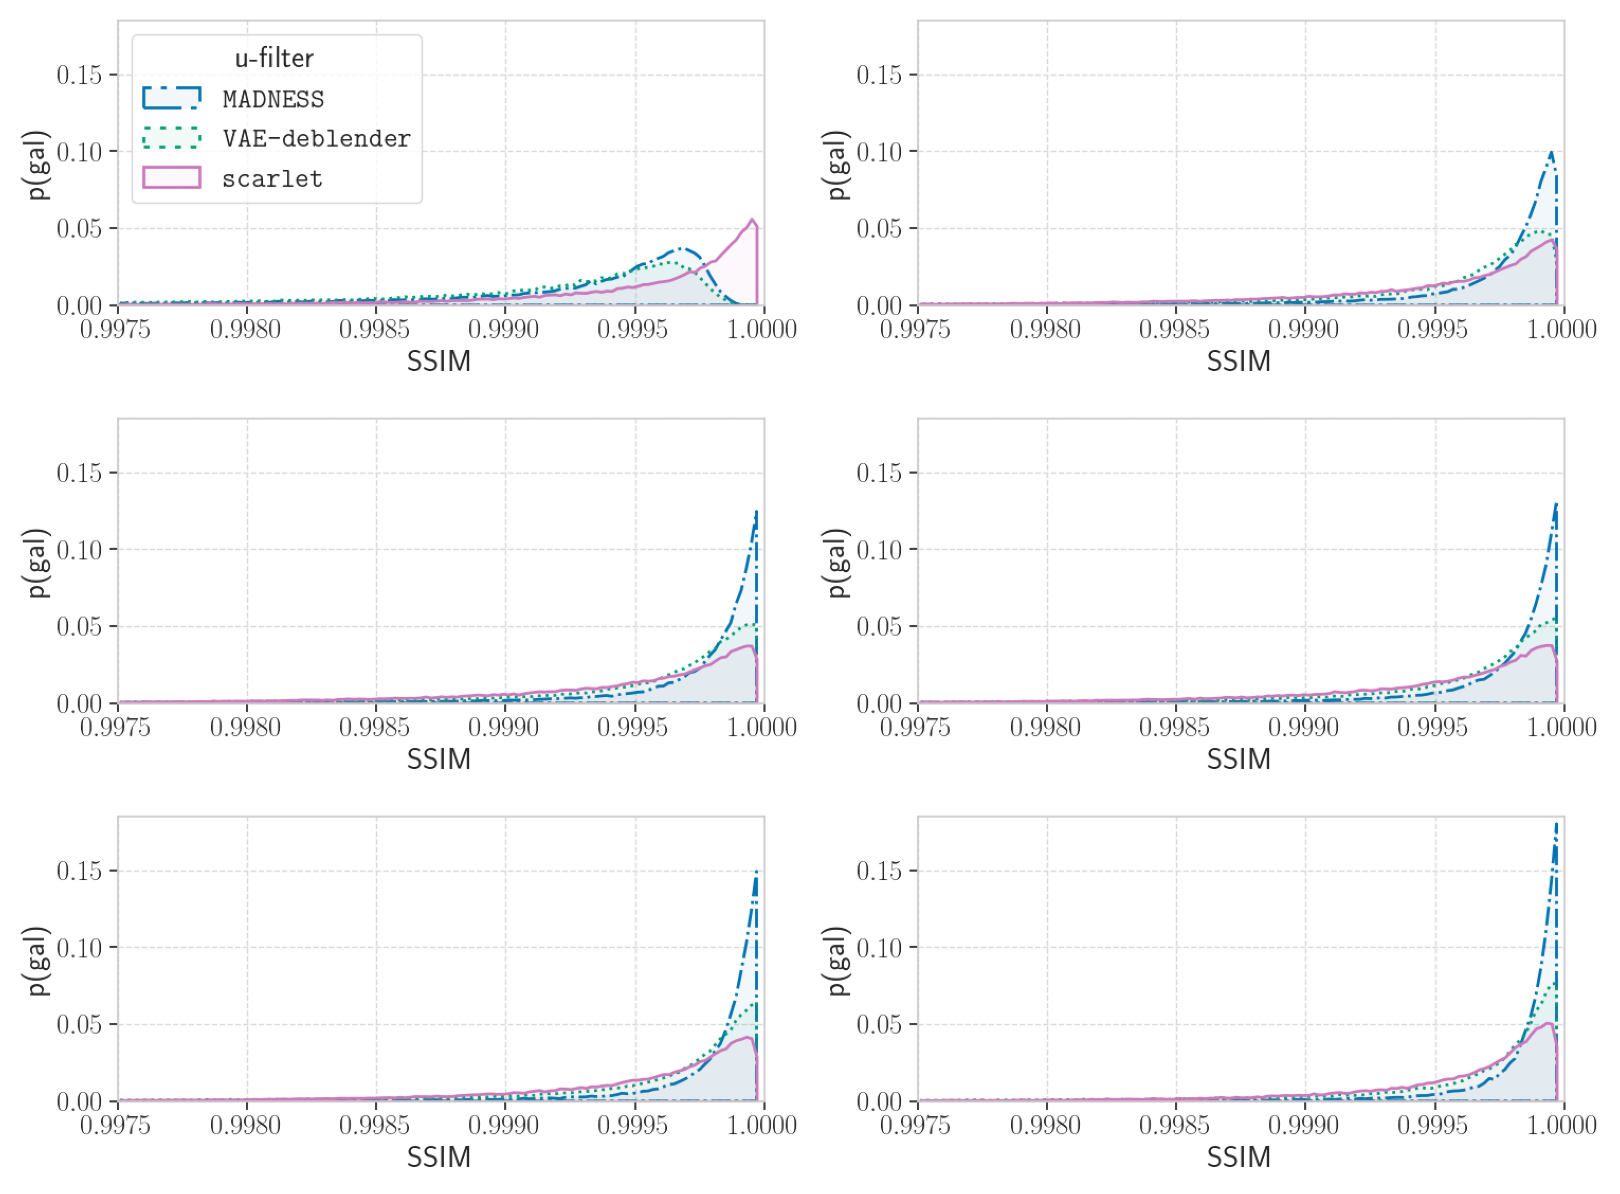

In [ ]:
f, axarr = plt.subplots(3, 2, figsize=(16, 12))

for band_num, band in enumerate(survey.available_filters):
#axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))
    axarr[int(band_num/2)][band_num%2].imshow(mpimg.imread(os.path.join("results", density_level + "_density", f"ssim_res_{band}.png")))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout(pad=0)


plt.savefig(os.path.join("results", density_level + "_density", "ssim_res.pdf"), format="pdf", bbox_inches="tight", dpi=1200)
plt.savefig(os.path.join("results", density_level + "_density", "ssim_res.png"))

plt.show()

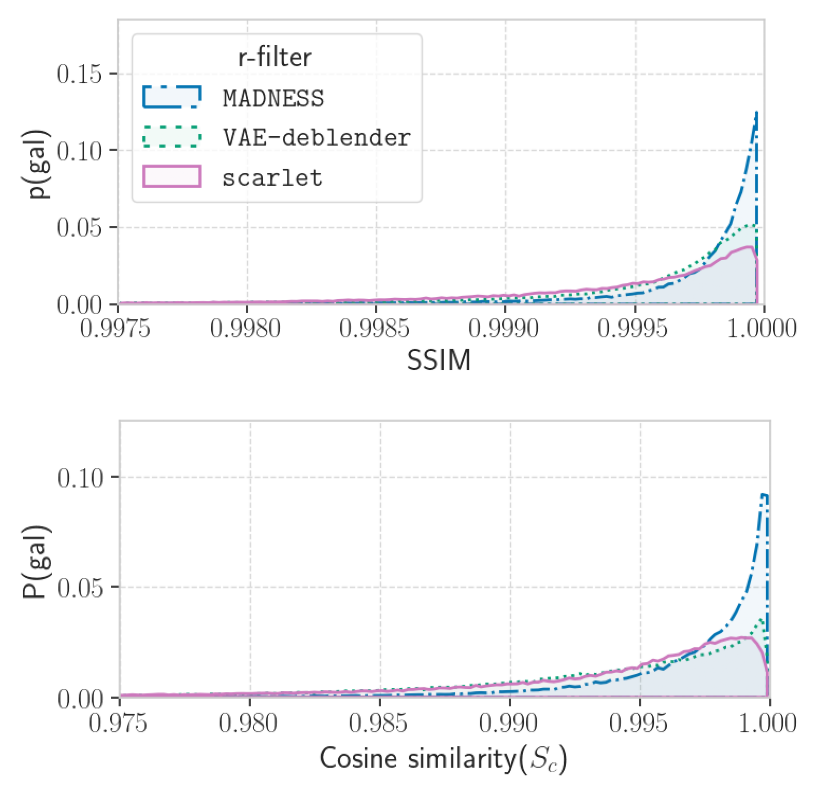

In [ ]:
f, axarr = plt.subplots(2, 1, figsize=(8, 8))


#axarr[0].imshow(mpimg.imread(os.path.join(result_dir_pth, "cumulative_distib_phot_err_r.png")))
axarr[0].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "ssim_res_r.png")))
axarr[1].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "cosd_res_r.png")))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
[ax.margins(y=0, x=0) for ax in axarr.ravel()]


plt.tight_layout(pad=0)

plt.savefig("results/" + density_level + "_density/morphology_results.pdf", format="pdf", bbox_inches="tight")
plt.savefig("results/" + density_level + "_density/morphology_results.png")

plt.show()

# Relative error in apperture photometry (elliptical apertures)

In [ ]:
for band in survey.available_filters:

    #sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    sns.set(font_scale=1.75)
    sns.set_style("whitegrid", {"grid.color": ".85", 'grid.linestyle': '--'})
#     sns.set_theme(style={"axes.grid": True,'grid.color': 'black',
# })
    plt.figure(figsize=(8, 5))
    bins = np.arange(-1, 1, 0.0001)
    mask = (actual_photometry[band+"_phot_flux"].values/actual_photometry[band+"_phot_fluxerrs"].values)>5
    x = sns.histplot(
        np.abs(madness_results[band+"_phot_flux"].values[mask] / actual_photometry[band+"_phot_flux"].values[mask] - 1),
        bins=bins,
        stat='density',
        alpha=.05,
        cumulative=True,
        color=madness_plot_color,
        element="step",
        ls=madness_plot_ls,
        linewidth=2,
        label=madness_plot_label,
    )
    #plt.plot([], [], ls=madness_plot_ls, lw=2, color=madness_plot_color, label=madness_plot_label)

    sns.histplot(
        np.abs(debvader_results[band+"_phot_flux"].values[mask] / actual_photometry[band+"_phot_flux"].values[mask] - 1),
        bins=bins,
        stat='density',
        alpha=.05,
        cumulative=True,
        color=debvader_plot_color,
        element="step",
        ls=debvader_plot_ls,
        linewidth=2,
        label=debvader_plot_label,
    )
    #plt.plot([], [], ls=debvader_plot_ls, lw=2, color=debvader_plot_color, label=debvader_plot_label)
    
    sns.histplot(
        np.abs(scarlet_results[band+"_phot_flux"].values[mask] / actual_photometry[band+"_phot_flux"].values[mask] - 1),
        bins=bins,
        stat='density',
        alpha=.05,
        cumulative=True,
        color=scarlet_plot_color,
        element="step",
        linewidth=2,
        ls=scarlet_plot_ls,
        label=scarlet_plot_label,
    )
    #plt.plot([], [], ls=scarlet_plot_ls, lw=2, color=scarlet_plot_color, label=scarlet_plot_label)

    sns.histplot(
        np.abs(blended_photometry[band+"_phot_flux"].values[mask] / actual_photometry[band+"_phot_flux"].values[mask] - 1),
        bins=bins,
        stat='density',
        alpha=.05,
        cumulative=True,
        color=blended_plot_color,
        ls=blended_plot_ls,
        linewidth=2,
        element="step",
        label="blended",
    )
    #plt.plot([], [], ls=blended_plot_ls, lw=2, color=blended_plot_color, label="blended")

    ax = plt.gca()
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    #ax.grid(color='lightgray', linestyle='-', linewidth=2)
    plt.xlim([0, .1])
    plt.ylim([.25, 1])
    plt.xlabel(r'$|\delta$(Aperture phot)$|$')
    plt.ylabel("cumulative fraction")
    plt.legend(title=f"{band}-filter", loc="lower right", title_fontsize=20)
    plt.tight_layout()
    plt.savefig("results/"+ density_level + "_density/cumulative_distib_phot_err_"+band)
    plt.savefig("results/"+ density_level + "_density/cumulative_distib_phot_err_"+band + ".pdf", format="pdf", bbox_inches="tight")
    plt.close()

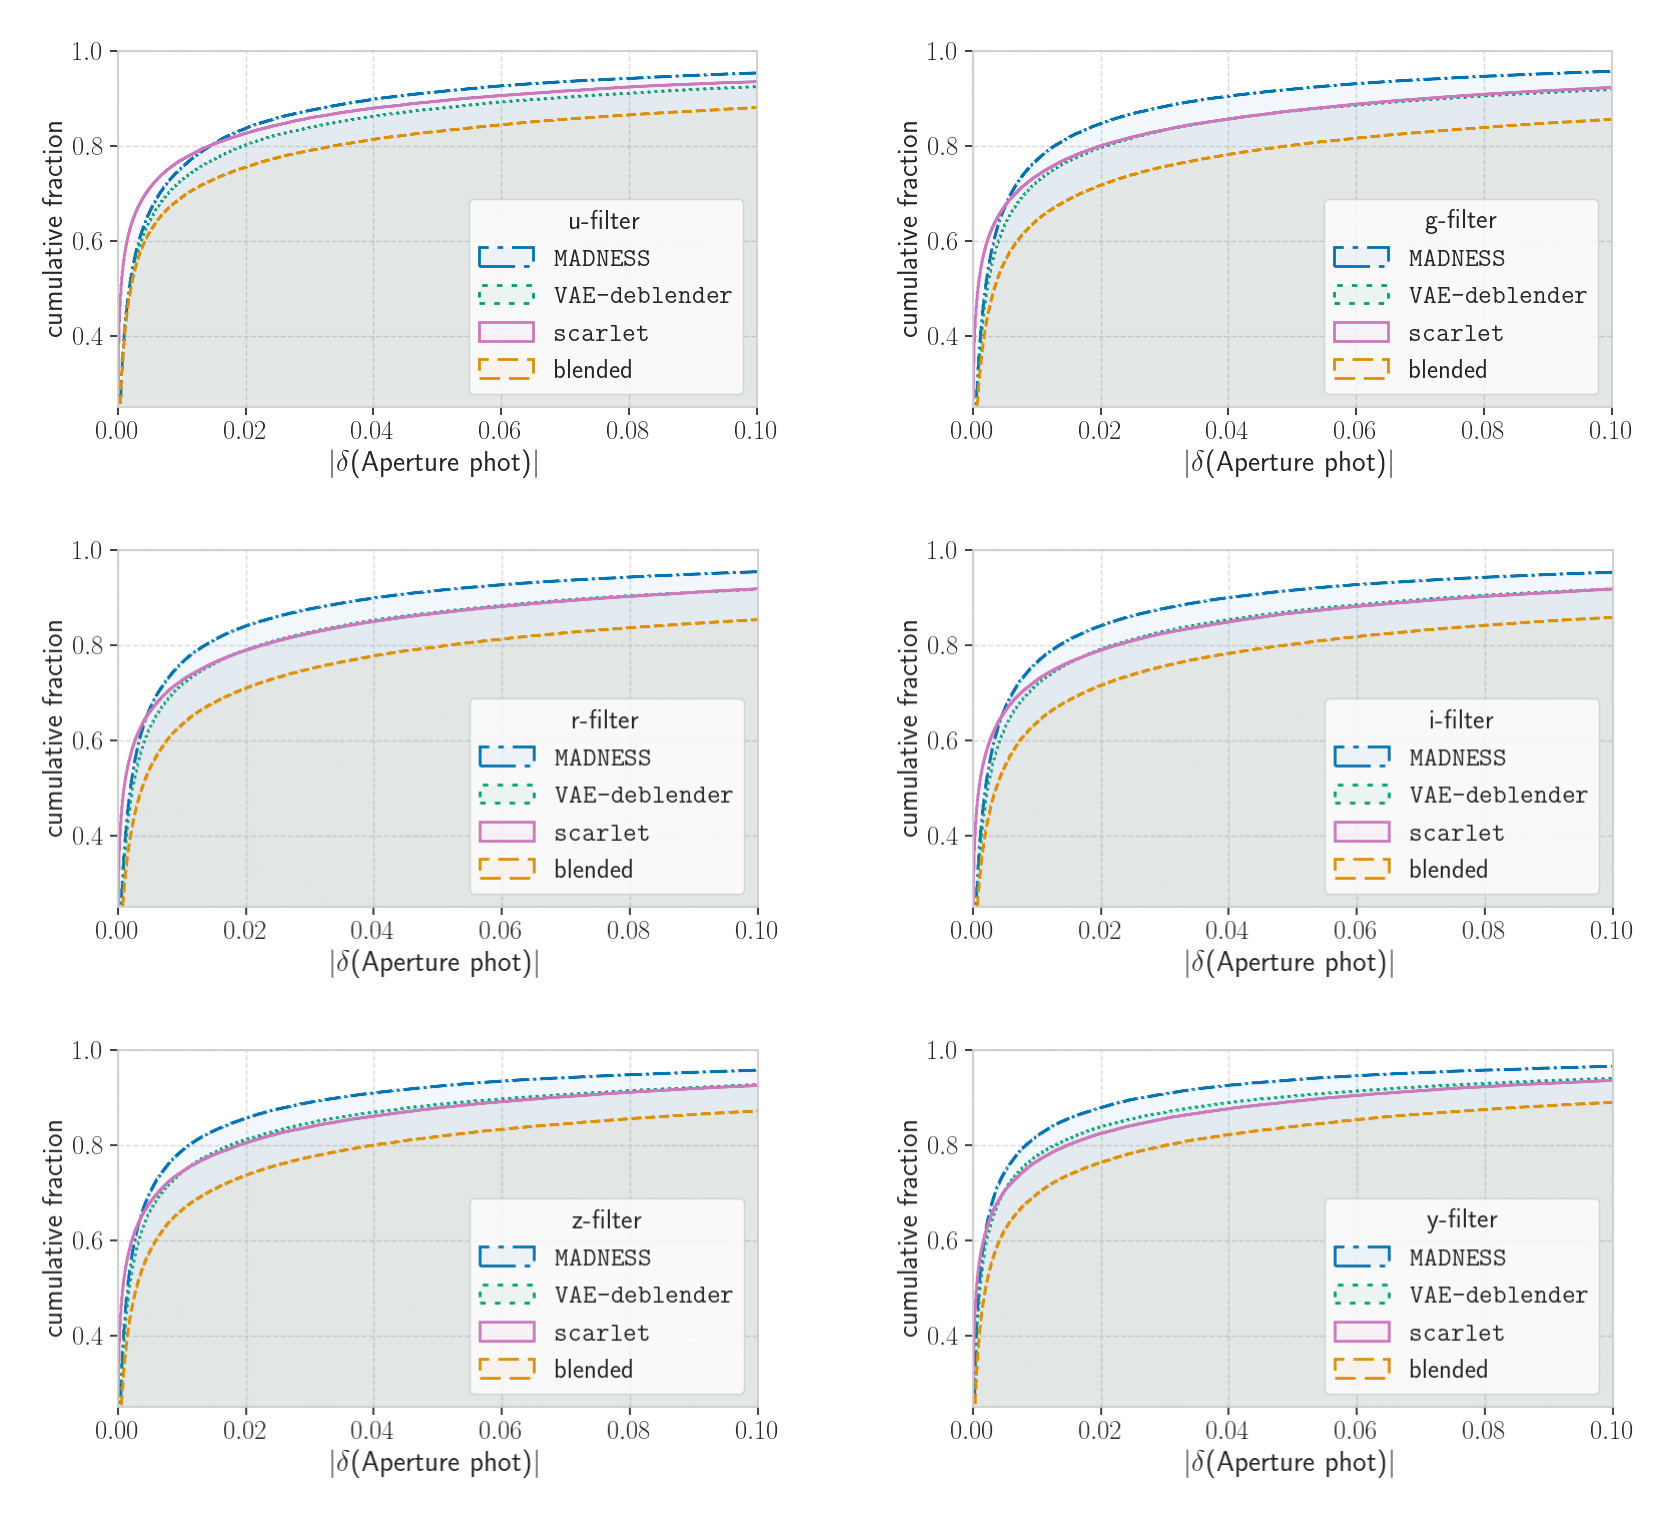

In [ ]:
f, axarr = plt.subplots(3, 2, figsize=(18, 15))

for band_num, band in enumerate(survey.available_filters):
#axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))
    axarr[int(band_num/2)][band_num%2].imshow(mpimg.imread(os.path.join("results", f"{density_level}_density/cumulative_distib_phot_err_{band}.png")))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout(pad=0)


plt.savefig(os.path.join("results", density_level + "_density", "cumulative_distib_phot_err.pdf"), format="pdf", bbox_inches="tight", dpi=1200)
plt.savefig(os.path.join("results", density_level + "_density", "cumulative_distib_phot_err.png"))

plt.show()

# Box plots

SNR definition here is one used to place the SNR>10 cut on the catalog.

In [ ]:
boxplot_snr_df = {}

r_snr_mask = (actual_photometry["r_phot_flux"].values/actual_photometry["r_phot_fluxerrs"].values)>5

# madness_actual_flux = madness_results[band+"_actual_flux"].value
# madness_predicted_flux = madness_results[band+"_predicted_flux"].value

# scarlet_actual_flux = scarlet_results[band+"_actual_flux"].value
# scarlet_predicted_flux = scarlet_results[band+"_predicted_flux"].value

# scarlet_relative_difference = np.divide(
#     scarlet_predicted_flux - scarlet_actual_flux, scarlet_actual_flux
# )
# madness_relative_difference = np.divide(
#     madness_predicted_flux - madness_actual_flux, madness_actual_flux
# )
boxplot_snr_df["snr"] = list(madness_results['r_band_snr'][r_snr_mask])
boxplot_snr_df["type"] = ["madness"] * len(madness_results[r_snr_mask])
#boxplot_snr_df["r_relative_flux_err"] = list(madness_relative_difference)
boxplot_snr_df["r_relative_flux_err"] = list(np.abs(madness_results["r_phot_flux"].values[r_snr_mask] - actual_photometry["r_phot_flux"].values[r_snr_mask]) / actual_photometry["r_phot_flux"].values[r_snr_mask])


boxplot_snr_df["snr"].extend(list(scarlet_results['r_band_snr'][r_snr_mask]))
boxplot_snr_df["type"].extend(["scarlet"] * len(scarlet_results[r_snr_mask]))
boxplot_snr_df["r_relative_flux_err"].extend(list(np.abs(scarlet_results["r_phot_flux"].values[r_snr_mask] - actual_photometry["r_phot_flux"].values[r_snr_mask]) / actual_photometry["r_phot_flux"].values[r_snr_mask])) 

boxplot_snr_df = pd.DataFrame(boxplot_snr_df)

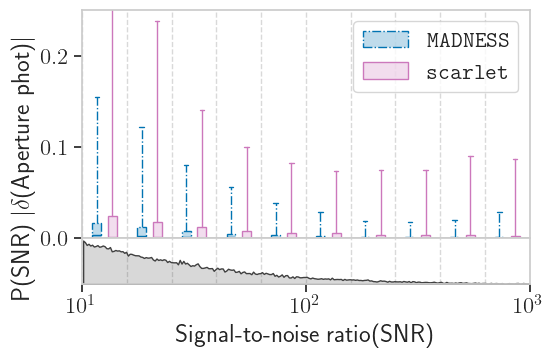

In [ ]:
fig, median_fluxerr, q1_fluxerr, q3_fluxerr, whislo_fluxerr, whishi_fluxerr = maddeb.boxplot.boxplot_func(
    boxplot_snr_df, 
    x = 'snr', y = "r_relative_flux_err", z = "type",
    xlim = (10, 1000),
    ylim = (0, 0.25), 
    x_scale = 'log',
    legend = [madness_plot_label, scarlet_plot_label],
    x_label='Signal-to-noise ratio(SNR)', 
    y_label = r'$|\delta$(Aperture phot)$|$',
    y_label_hist='P(SNR)',
    legend_remove = False,
    legend_location = "upper right",
#     x_ticks=[10, 20, 30, 40, 60, 100],
#     x_ticklabels=[r'$10$', r'$20$', r'$30$', r'$40$', r'$60$', r'$100$'],
    whis = [5,95],
    percents = [25,75],
    palette = [madness_plot_color, scarlet_plot_color],#0.35,
    ls = [madness_plot_ls, scarlet_plot_ls],
    nbins = 10,
    x_major_grid=True,
    sns_font_scale=1.5,
)

plt.savefig(os.path.join("results", density_level + "_density", "snr_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "snr_box_plot.png"))

In [ ]:
madness_results

,u_cosd,u_ssim,u_blendedness,g_cosd,g_ssim,g_blendedness,r_cosd,r_ssim,r_blendedness,i_cosd,...,i_phot_flux,i_phot_fluxerrs,i_phot_flags,z_phot_flux,z_phot_fluxerrs,z_phot_flags,y_phot_flux,y_phot_fluxerrs,y_phot_flags,r_contamination
0,0.980648,0.999080,0.131162,0.990550,0.999745,0.469463,0.991241,0.999790,0.655093,0.988515,...,22714.902422,3412.864287,0,33815.348813,3902.107847,0,16987.817949,4187.370411,0,1.911186
1,0.983270,0.999057,0.008478,0.999401,0.999959,0.007969,0.999839,0.999989,0.011934,0.999820,...,142616.530585,3224.489218,0,121263.275793,3667.382735,0,66857.276630,3942.447703,0,0.011798
2,0.000000,NaN,0.049146,0.101025,0.991412,0.030588,0.992595,0.999483,0.008035,0.995592,...,42592.580367,3432.091843,0,51986.568549,3926.199075,0,31274.260560,4220.803040,0,0.007196
3,0.178926,0.994366,0.867055,0.992459,0.999648,0.525110,0.997493,0.999919,0.338726,0.997027,...,77551.000280,3245.959683,0,71616.150903,3690.316748,0,36641.610318,3974.993790,0,0.545165
4,0.992832,0.999662,0.002891,0.997112,0.999792,0.002766,0.996531,0.999772,0.004563,0.995947,...,27882.272252,3452.271422,0,22245.872272,3933.776179,0,12399.981383,4238.802282,0,0.004191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,0.968596,0.998348,0.001313,0.996090,0.999809,0.001797,0.997945,0.999862,0.001156,0.997275,...,39069.600893,3416.239746,0,48538.895310,3896.849843,0,37810.870059,4158.436400,0,0.000549
323,0.993737,0.999357,0.000992,0.996622,0.999739,0.001400,0.996610,0.999764,0.002615,0.997299,...,15766.236891,3753.979622,0,11355.264152,4308.768662,0,8098.229498,4618.465489,0,0.001450
324,0.993655,0.999309,0.000265,0.998862,0.999850,0.000547,0.999127,0.999897,0.001049,0.999330,...,105518.948337,4178.788807,0,80807.926799,4801.635003,0,37901.785129,5145.417179,0,0.000625
325,0.650691,0.994872,0.002836,0.998151,0.999880,0.000468,0.999848,0.999988,0.000123,0.999908,...,421509.586069,3517.234089,0,368955.557449,4024.485017,0,208146.561139,4310.990020,0,0.000068


In [ ]:
boxplot_blendedness_df = {}

boxplot_blendedness_df['r_blendedness'] = list(madness_results['r_blendedness'][r_snr_mask])
boxplot_blendedness_df['r_contamination'] = list(madness_results['r_contamination'][r_snr_mask])
boxplot_blendedness_df["type"] = ["madness"] * len(madness_results[r_snr_mask])
boxplot_blendedness_df["r_relative_flux_err"] = list(np.abs(madness_results["r_phot_flux"].values[r_snr_mask] - actual_photometry["r_phot_flux"].values[r_snr_mask]) / actual_photometry["r_phot_flux"].values[r_snr_mask])


boxplot_blendedness_df['r_blendedness'].extend(list(scarlet_results['r_blendedness'][r_snr_mask]))
boxplot_blendedness_df['r_contamination'].extend(list(madness_results['r_contamination'][r_snr_mask]))
boxplot_blendedness_df["type"].extend(["scarlet"] * len(scarlet_results[r_snr_mask]))
boxplot_blendedness_df["r_relative_flux_err"].extend(list(np.abs(scarlet_results["r_phot_flux"].values[r_snr_mask] - actual_photometry["r_phot_flux"].values[r_snr_mask]) / actual_photometry["r_phot_flux"].values[r_snr_mask])) 

boxplot_blendedness_df = pd.DataFrame(boxplot_blendedness_df)

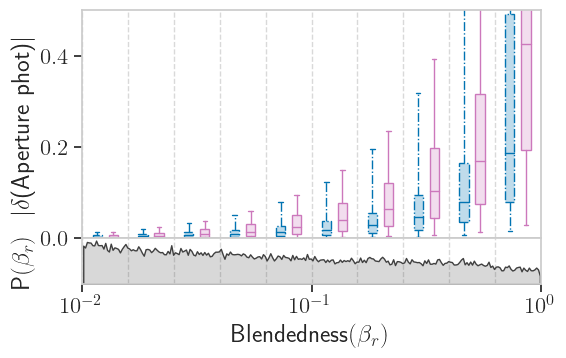

In [ ]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_blendedness_df, 
    x = 'r_blendedness', y = "r_relative_flux_err", z = "type",
    xlim = (1e-2, 1),
    ylim = (-0, .5), 
    x_scale = 'log',
    legend = [madness_plot_label, scarlet_plot_label],
    x_label=r'Blendedness$(\beta_r)$', 
    y_label = r'$|\delta$(Aperture phot)$|$',
    y_label_hist=r'P$(\beta_r)$',
    legend_remove = True,
    whis = [5, 95],
    percents = [25, 75],
    palette=[madness_plot_color, scarlet_plot_color],#0.35,
    ls = [madness_plot_ls, scarlet_plot_ls],
    nbins = 10,
    x_major_grid=True,
    sns_font_scale=1.5,
)
plt.savefig(os.path.join("results", density_level + "_density", "blendedness_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density",  "blendedness_box_plot.png"))

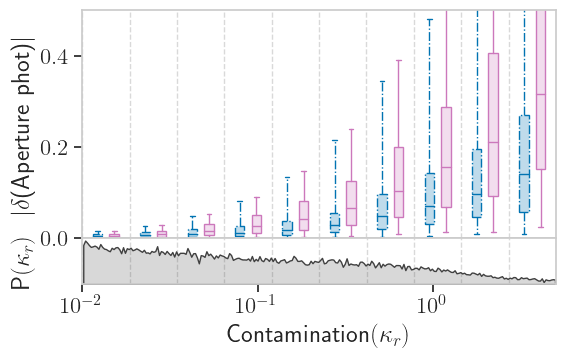

In [ ]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_blendedness_df, 
    x = 'r_contamination', y = "r_relative_flux_err", z = "type",
    xlim = (1e-2, 5),
    ylim = (0, .5), 
    x_scale = 'log',
    legend = [madness_plot_label, scarlet_plot_label],
    x_label=r'Contamination$(\kappa_r)$', 
    y_label = r'$|\delta$(Aperture phot)$|$',
    y_label_hist=r'P$(\kappa_r)$',
    legend_remove = True,
    whis = [5, 95],
    percents = [25, 75],
    palette=[madness_plot_color, scarlet_plot_color],#0.35,
    ls = [madness_plot_ls, scarlet_plot_ls],
    nbins = 10,
    sns_font_scale=1.5,
)
plt.savefig(os.path.join("results", density_level + "_density", "contamination_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density",  "contamination_box_plot.png"))

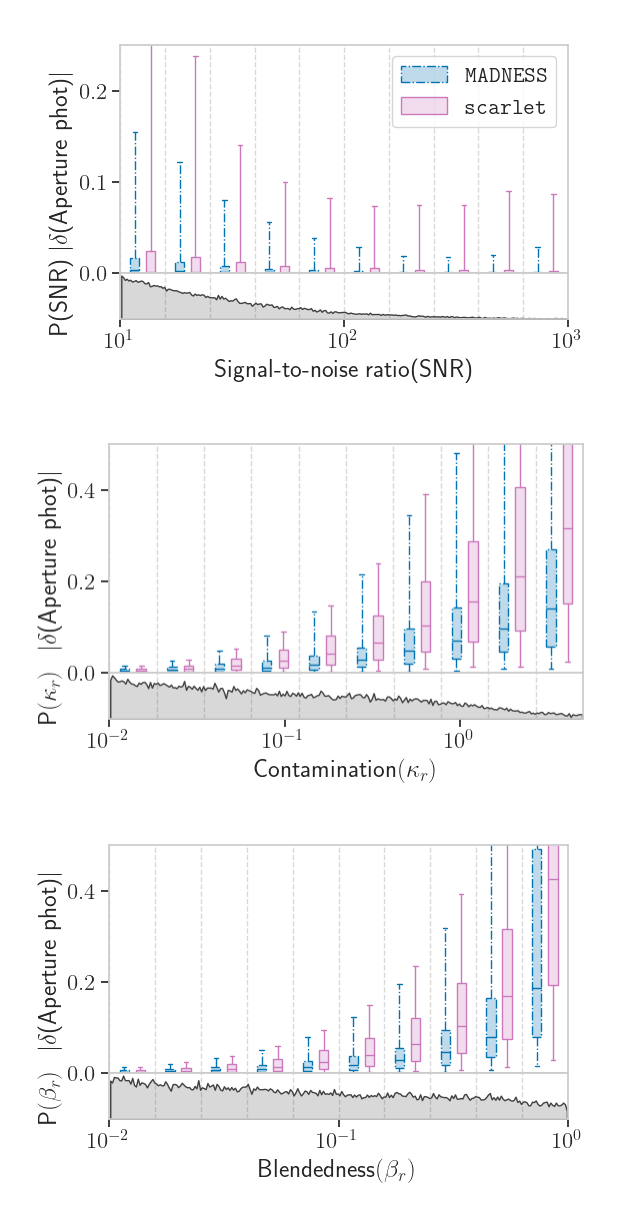

In [ ]:
f, axarr = plt.subplots(3, 1, figsize=(6, 12))


#axarr[0].imshow(mpimg.imread(os.path.join(result_dir_pth, "cumulative_distib_phot_err_r.png")))
axarr[0].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "snr_box_plot.png")))
axarr[1].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "contamination_box_plot.png")))
axarr[2].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "blendedness_box_plot.png")))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
[ax.margins(y=0, x=0) for ax in axarr.ravel()]


plt.tight_layout(pad=0)

plt.savefig("results/" + density_level + "_density/boxplot_results.pdf", format="pdf", bbox_inches="tight")
plt.savefig("results/" + density_level + "_density/boxplot_results.png")

plt.show()